In [9]:
if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    sys.path.append(str(curr_file_path.parent))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import torch
from sklearn.decomposition import PCA
from agents.networks.gru_rnn import GRU_RNN

AVERAGING_SIZE = 20

color_set_1 = [
    '#E4F1F7',
    '#C5E1EF',
    '#9EC9E2',
    '#6CB0D6',
    '#3C93C2',
    '#226E9C',
    '#0D4A70',
    '#054166',
]

color_set_2 = [
    '#F9D8E6',
    '#F2ACCA',
    '#ED85B0',
    '#E95694',
    '#E32977',
    '#C40F5B',
    '#8F003B',
    '#69022c',
]

HIDDEN_SIZE = 32
INPUT_SIZE = 1

In [10]:
hypo_data = [
    'test_line_attractor_init_0_early_2024-12-18_10_33_33_962484_var_noise_5e-05_activity_weight_1e-07',
]

ctrl_data = [
]

In [11]:
def load_numpy(data_path, averaging_size=1, concat_ax=0):
    file_names = glob.glob(data_path)
    data = []
    for file_name in file_names:
        data_for_file = np.load(file_name)
        data.append(data_for_file)
    data = np.concatenate(data, axis=concat_ax)
    if averaging_size == 1:
        return data
    reduced_data = np.empty((data.shape[0], int(data.shape[1] / averaging_size)))
    for k in range(0, int(data.shape[1] / averaging_size) * averaging_size, averaging_size):
        reduced_data[:, int(k / averaging_size)] = data[:, k:k + averaging_size].mean(axis=1)
    return reduced_data

In [12]:
hidden_state_data = None
for i_d, d in enumerate(hypo_data):
    hs_path = f'../../results/line_attr_supervised/{d}/hidden_states/*.npy'
    o_path = f'../../results/line_attr_supervised/{d}/outputs/*.npy'
    hidden_state_data = load_numpy(hs_path)
    output_data = load_numpy(o_path, concat_ax=1)

print(hidden_state_data.shape)

(2000, 32, 500)


(2, 2000)


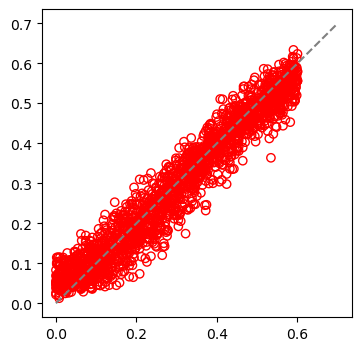

In [13]:
scale = 1
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

# output_data = output_data.reshape((2, 2000), order='F')
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], output_data[0, :], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')

[0.01263486 0.01866919 0.01897686 ... 0.6165387  0.6234315  0.63352257]
0
200
400
600
800
1000
1200
1400
1600
1800


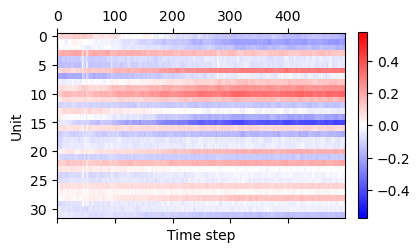

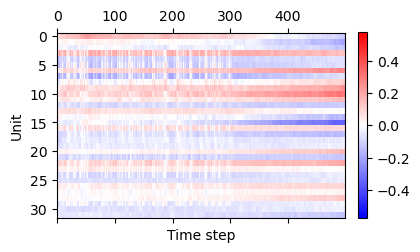

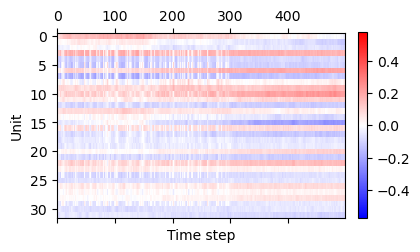

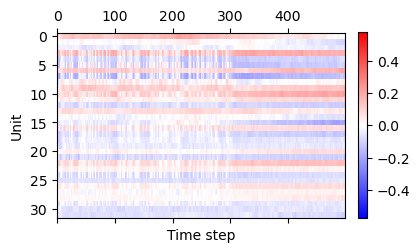

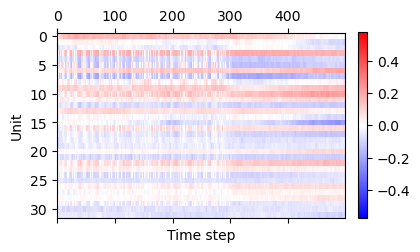

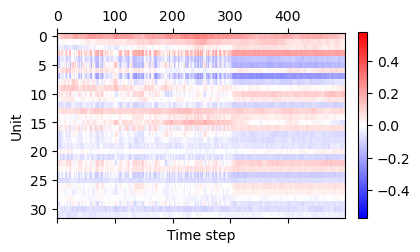

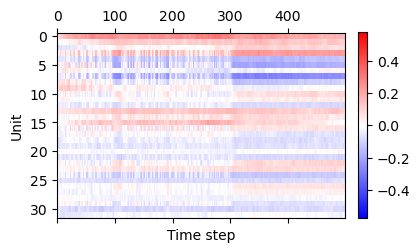

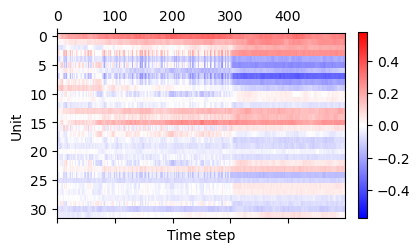

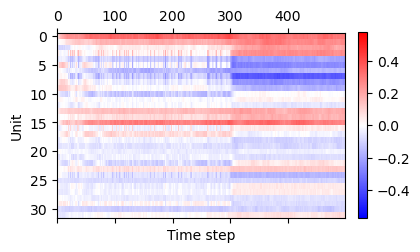

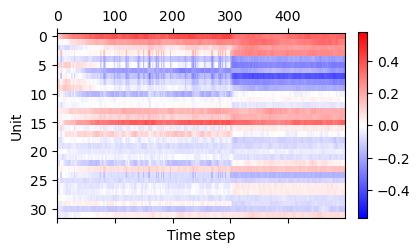

In [14]:
m = np.abs(hidden_state_data).max()

sorted_hidden_activity = hidden_state_data[output_data[0, :].argsort(), ...]

print(output_data[0, :][output_data[0, :].argsort()])

for k in range(0, 2000, 200):
    print(k)
    hidden_activity = sorted_hidden_activity[k, ...]
    
    scale = 1
    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
    axs.set_ylabel('Unit')
    axs.set_xlabel('Time step')

    cbar = axs.matshow(hidden_activity, vmin=-m, vmax=m, cmap='bwr', aspect=10)
    plt.colorbar(cbar, fraction=0.03, pad=0.04)

# PC space representation

(32, 2000, 500)
(32, 1000000)
[[ 0.31079134  0.30853653  0.2029542   0.00286643 -0.09271957 -0.08342668
  -0.37192255 -0.15516715 -0.19708145 -0.23549512 -0.2590266  -0.07853927
   0.07292847  0.13471061  0.20539857  0.48539346 -0.05388275  0.14150849
  -0.01906083 -0.0373964  -0.12449905  0.04911448 -0.15634894  0.07576805
  -0.06277549 -0.03103768 -0.06566954 -0.00726435 -0.12056935  0.00852225
  -0.05938242  0.14155908]
 [ 0.12636979 -0.05636161 -0.2053165  -0.35116374  0.15207404  0.4184012
  -0.06855298  0.3823686   0.26583642  0.18070555 -0.2725603  -0.0690433
   0.10215406 -0.02005859 -0.08950062  0.11853959 -0.14547424  0.19888239
   0.10766581  0.02085339 -0.04947184  0.07188878 -0.2639648  -0.08397894
   0.1455334   0.01778785 -0.15908207 -0.12380545 -0.00743656  0.17196797
  -0.03074884 -0.03490464]
 [ 0.29138917 -0.0305027  -0.22181068  0.18939012 -0.03348377 -0.09538319
   0.38811362  0.03000777  0.11238131  0.15667917 -0.11569335 -0.30238536
  -0.03450502  0.02410107  0.2

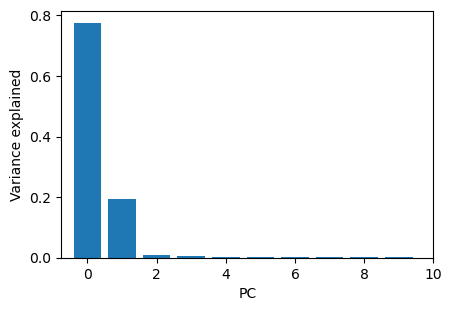

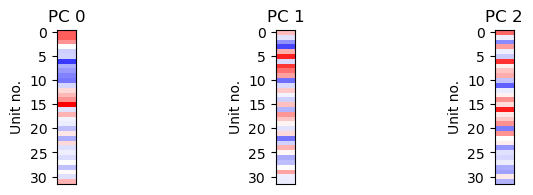

In [15]:
data_ = np.transpose(hidden_state_data, [1, 0, 2])
flattened_data = data_.reshape(data_.shape[0], data_.shape[1] * data_.shape[2])
print(data_.shape)
print(flattened_data.shape)
pca = PCA()
pc_activities = pca.fit_transform(flattened_data.T)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 2

print(pca.components_[:3, :])
fig, axs = plt.subplots(1, 3, figsize=(4 * scale, 1 * scale))
m = np.abs(pca.components_[:3, :]).max()
for i in range(3):
    axs[i].matshow(pca.components_[i, :].reshape(HIDDEN_SIZE, 1), vmin=-m, vmax=m, cmap='bwr', aspect=0.25)
    axs[i].set_xticks([])
    axs[i].set_ylabel('Unit no.')
    axs[i].set_title(f'PC {i}')

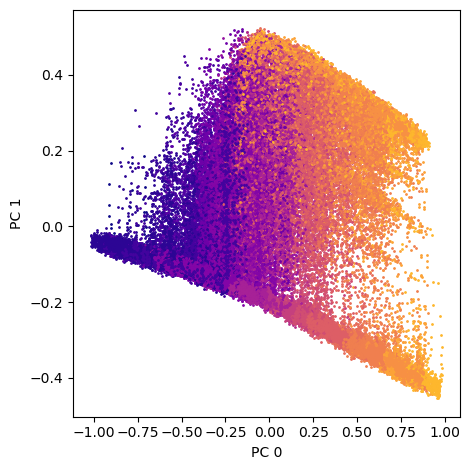

In [16]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 20))

for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1), k],
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[int(output_data[0, run_idx] * 20 / 0.7)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

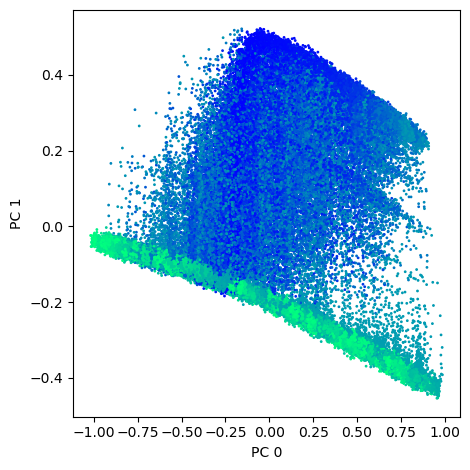

In [17]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['winter']
colors = cmap(np.linspace(0, 1, 500))

for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1), k],
            pc_activities[hidden_state_data.shape[2] * run_idx:hidden_state_data.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[np.arange(500)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

(20, 2000, 500)
(20, 1000000)
[[ 0.32417262  0.32515225  0.21695101  0.00878298 -0.09983125 -0.09450122
  -0.38965    -0.16944273 -0.21165228 -0.25060222 -0.26734668 -0.08107935
   0.07485338  0.14187491  0.21717803  0.5078747  -0.0546562   0.14518271
  -0.02189334 -0.03978792]
 [ 0.16259077 -0.03968994 -0.21175887 -0.38734433  0.16202742  0.45687574
  -0.10054389  0.41138968  0.27935115  0.182527   -0.3193942  -0.08220516
   0.1175982  -0.01225104 -0.08322749  0.1660358  -0.16523959  0.22927694
   0.11780963  0.02058689]
 [ 0.37838957  0.00286462 -0.21494673  0.22779025 -0.03651705 -0.10941781
   0.43613774  0.02027773  0.10731655  0.16399285 -0.125691   -0.3323083
  -0.04033761  0.05116005  0.25272748  0.10903335  0.48106858  0.05496626
   0.13217083  0.24131039]]


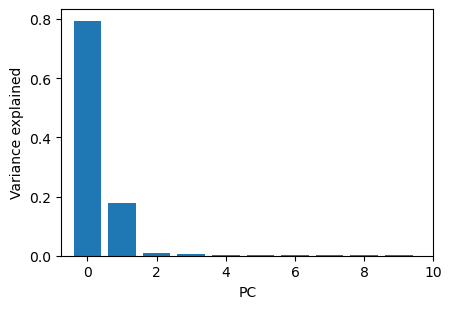

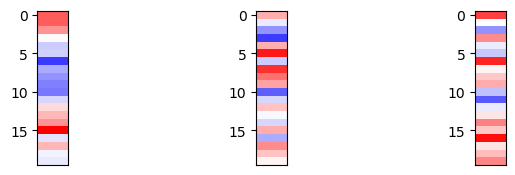

In [18]:
data_ = np.transpose(hidden_state_data, [1, 0, 2])
data_ = data_[:20, ...]
flattened_data = data_.reshape(data_.shape[0], data_.shape[1] * data_.shape[2])
print(data_.shape)
print(flattened_data.shape)
pca = PCA()
pc_activities = pca.fit_transform(flattened_data.T)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

scale = 2

print(pca.components_[:3, :])
fig, axs = plt.subplots(1, 3, figsize=(4 * scale, 1 * scale))
m = np.abs(pca.components_[:3, :]).max()
for i in range(3):
    axs[i].matshow(pca.components_[i, :].reshape(20, 1), vmin=-m, vmax=m, cmap='bwr', aspect=0.25)
    axs[i].set_xticks([])

C:\Users\david.bell\AppData\Local\Temp\ipykernel_42628\621727634.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs.scatter(


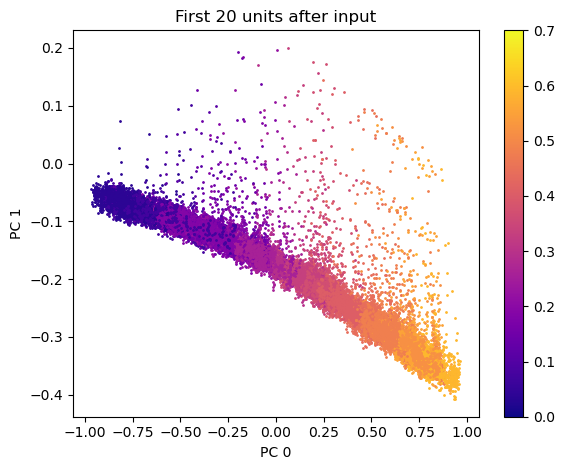

In [19]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(5 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 20))


for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        axs.scatter(
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            c=colors[int(output_data[0, run_idx] * 20 / 0.7)],
            # vmax=2,
        )
sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(0, 0.7)
plt.colorbar(sm, ax=axs)
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
axs.set_title('First 20 units after input')
    # fig.colorbar(cbar)
fig.tight_layout()

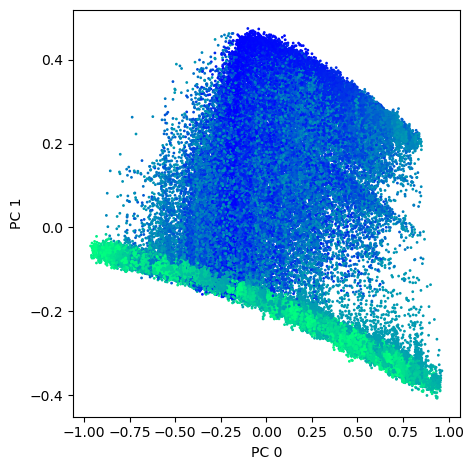

In [20]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
cmap = mpl.colormaps['winter']
colors = cmap(np.linspace(0, 1, 500))


for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[np.arange(500)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

(12, 2000, 500)
(12, 1000000)


Text(0.5, 0, 'PC')

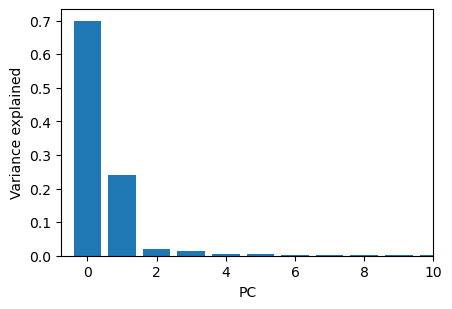

In [21]:
data_ = np.transpose(hidden_state_data, [1, 0, 2])
data_ = data_[20:, ...]
flattened_data = data_.reshape(data_.shape[0], data_.shape[1] * data_.shape[2])
print(data_.shape)
print(flattened_data.shape)
pca = PCA()
pc_activities = pca.fit_transform(flattened_data.T)
explained_variance_ratios = pca.explained_variance_ratio_

scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')

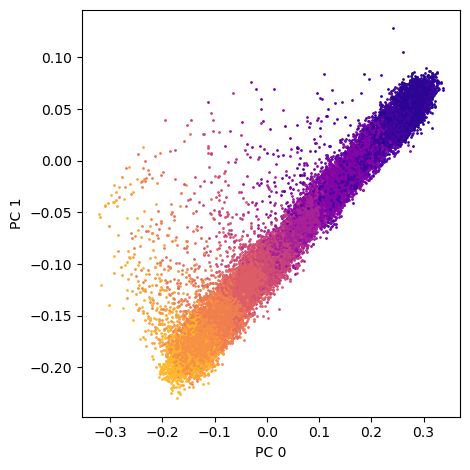

In [22]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 20))


for run_idx in range(0, 200, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx + 300:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[int(output_data[0, run_idx] * 20 / 0.7)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

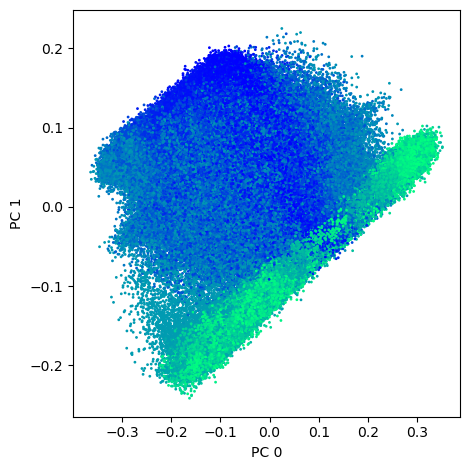

In [23]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['winter']
colors = cmap(np.linspace(0, 1, 500))


for run_idx in range(0, 1000, 1):
    for k in np.arange(0, 2, 2):
        cbar = axs.scatter(
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k],
            pc_activities[data_.shape[2] * run_idx:data_.shape[2] * (run_idx + 1), k + 1],
            s=1,
            color=colors[np.arange(500)],
            # vmax=2,
        )
axs.set_xlabel(f'PC 0')
axs.set_ylabel(f'PC 1')
    # fig.colorbar(cbar)
fig.tight_layout()

In [24]:
all_w_hh_trained = []
all_w_out = []
all_b_out = []

for i_d, d in enumerate(hypo_data):

    network_trained = GRU_RNN(
        input_size=INPUT_SIZE,
        hidden_size=HIDDEN_SIZE,
        device='cpu',
        var_noise=1e-7,
    )
    
    load_path = f'../../results/line_attr_supervised/{d}/rnn_weights/weights.h5'
    network_trained.load_state_dict(torch.load(load_path, weights_only=True))
    
    w_hh_trained = network_trained.rnn.weight_hh.detach().numpy()
    all_w_hh_trained.append(w_hh_trained)

    all_w_out.append(network_trained.output_arm.weight.detach().numpy())
    all_b_out.append(network_trained.output_arm.bias.detach().numpy())

(2000, 32, 500)
(2, 2000)


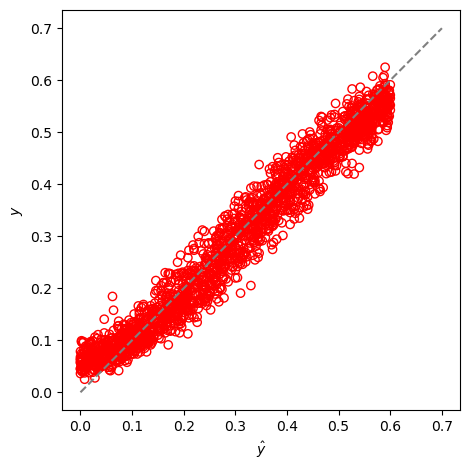

In [25]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 10))

print(hidden_state_data.shape)
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], np.dot(all_w_out[0].flatten(), (hidden_state_data[..., 300:].mean(axis=2)).T) + all_b_out[0], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')


axs.set_ylabel(r'$y$')
axs.set_xlabel(r'$\hat{y}$')
    # fig.colorbar(cbar)
fig.tight_layout()

(2000, 32, 500)
(2, 2000)


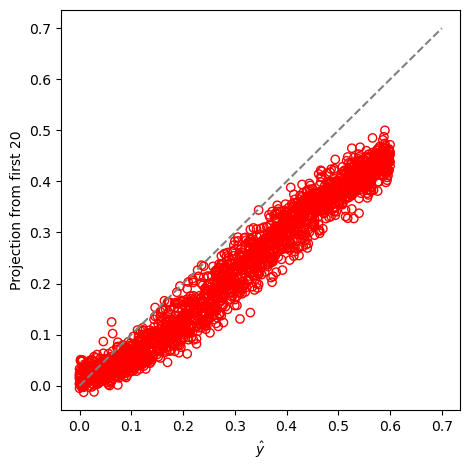

In [26]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 10))

print(hidden_state_data.shape)
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], np.dot(all_w_out[0].flatten()[:20], (hidden_state_data[:, :20, 300:].mean(axis=2)).T) + all_b_out[0], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')


axs.set_ylabel(r'Projection from first 20')
axs.set_xlabel(r'$\hat{y}$')
    # fig.colorbar(cbar)
fig.tight_layout()

(2000, 32, 500)
(2, 2000)


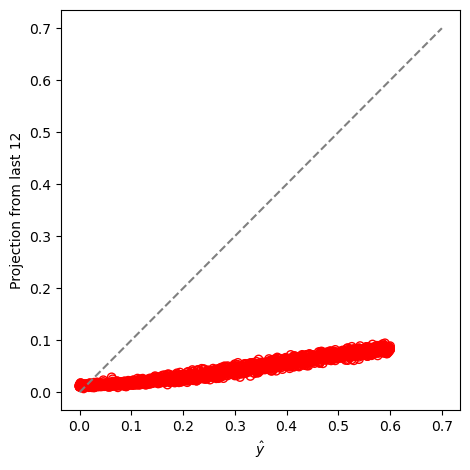

In [27]:
scale = 1.2
fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))

cmap = mpl.colormaps['plasma']
colors = cmap(np.linspace(0, 1, 10))

print(hidden_state_data.shape)
print(output_data.shape)

cbar = axs.scatter(output_data[1, :], np.dot(all_w_out[0].flatten()[20:], (hidden_state_data[:, 20:, 300:].mean(axis=2)).T) + all_b_out[0], edgecolor='red', facecolor='none')
axs.plot([0, 0.7], [0, 0.7], '--', c='gray')


axs.set_ylabel(r'Projection from last 12')
axs.set_xlabel(r'$\hat{y}$')
    # fig.colorbar(cbar)
fig.tight_layout()